In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.device('cuda')

device(type='cuda')

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size

        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)

            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X, Y = build_dataset(words)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [7]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5 / 3) / ((n_embd * block_size) ** 0.5)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))
for p in parameters: p.requires_grad = True

12297


In [8]:
# hpreact.std(0, keepdim=True)

In [9]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi


    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = lrs[i]
    lr = 0.1 if i <= 100000 else 0.01
    # lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3152
  10000/ 200000: 2.3465
  20000/ 200000: 2.5828
  30000/ 200000: 2.3871
  40000/ 200000: 1.9829
  50000/ 200000: 2.2151
  60000/ 200000: 1.7259
  70000/ 200000: 1.9420
  80000/ 200000: 2.1740
  90000/ 200000: 2.2269
 100000/ 200000: 2.0901
 110000/ 200000: 2.1993
 120000/ 200000: 2.1242
 130000/ 200000: 2.4608
 140000/ 200000: 2.1305
 150000/ 200000: 2.0014
 160000/ 200000: 2.1049
 170000/ 200000: 2.3877
 180000/ 200000: 2.3555
 190000/ 200000: 2.3739


torch.Size([32, 200])

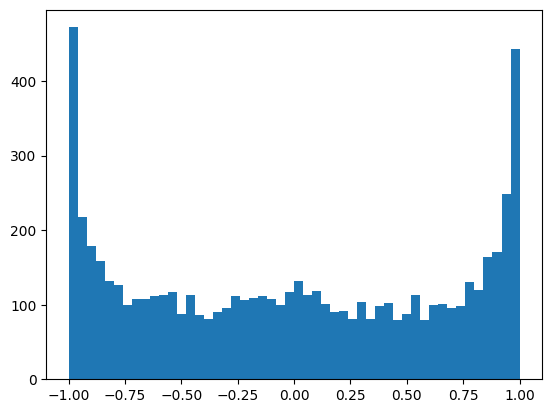

In [10]:
plt.hist(h.view(-1).tolist(), 50)
h.shape

In [11]:
logits[0]

tensor([ 0.6751,  3.8843, -1.4293,  0.0048, -1.7335,  4.5820, -1.4127, -1.7811,
         3.9004,  3.3974, -1.7270,  0.8658,  0.7333, -2.1319, -1.5910,  3.7622,
        -1.4295, -2.1334, -1.4642, -0.4385, -0.2333,  3.9210, -3.5359, -1.2120,
        -2.8584,  2.1780, -2.5340], grad_fn=<SelectBackward0>)

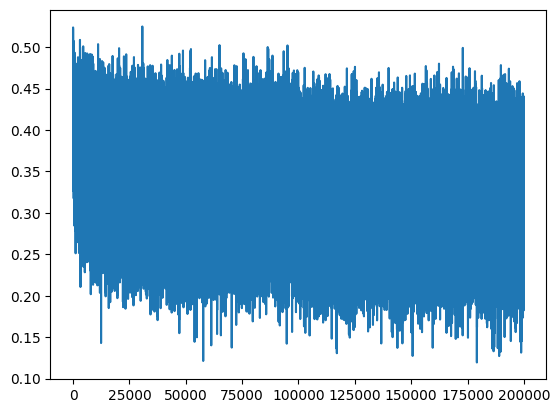

In [12]:
plt.plot(lossi)

In [13]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [14]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1

    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [17]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    # hpreact = 
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0655972957611084
val 2.1058859825134277


In [16]:
for _ in range(1):
    out = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor([context])]
        # print(emb.view(-1, 30))
        # print(W1.shape)
        h = torch.tanh(emb.view(1, -1) @ W1)
        logits = h @ W2 + b2
        # print(logits)
        probs = F.softmax(logits, dim=1);
        ix = torch.multinomial(probs, num_samples=1).item()
        print(probs, ix)
        print(ix, probs[:, ix].item())
        
        prob_sum = 0
        for j in range(27):
            # print(j, itos[j], probs[:, j].item())
            prob_sum += probs[:, j].item()
        
        print(prob_sum)
        if ix == 0:
            break

        context = context[1:] + [ix]
        out.append(ix)

    print(''.join(itos[i] for i in out))

tensor([[1.1329e-04, 8.7515e-03, 6.0116e-02, 2.1528e-02, 7.5945e-02, 2.8771e-03,
         5.0209e-02, 1.1280e-02, 1.0036e-02, 6.0345e-04, 4.5063e-02, 1.5219e-01,
         5.3868e-02, 1.5096e-02, 1.5363e-02, 4.8378e-04, 8.9955e-02, 1.1655e-01,
         2.5887e-02, 4.1451e-02, 8.9456e-02, 2.0677e-04, 5.8441e-02, 6.8706e-03,
         7.0368e-03, 1.8477e-03, 3.8776e-02]], grad_fn=<SoftmaxBackward0>) 22
22 0.058441322296857834
1.0000000623622327
tensor([[1.0755e-04, 2.2006e-01, 8.0474e-04, 2.7506e-04, 1.1953e-04, 1.0159e-01,
         7.6567e-03, 1.0188e-04, 1.1419e-02, 3.0556e-01, 5.2863e-04, 4.4775e-04,
         1.1275e-02, 1.8294e-04, 5.1388e-04, 3.9724e-02, 4.9995e-04, 5.8267e-04,
         2.4403e-01, 3.1975e-04, 2.7996e-03, 2.3867e-03, 1.1977e-02, 5.3113e-04,
         5.5778e-05, 3.0996e-02, 5.4534e-03]], grad_fn=<SoftmaxBackward0>) 1
1 0.22006160020828247
1.0000000125037332
tensor([[1.9738e-04, 3.1056e-03, 2.3479e-02, 1.3175e-02, 2.2048e-01, 2.2899e-03,
         2.2490e-02, 1.2640e-02,